# 🚨 Fraud Detection Model
### Identify Suspicious Claim Activities Using Demographic, Policy, and Risk Data

This notebook builds a supervised ML model to detect potential fraudulent behavior using:   
- Risk indicators  
- Claim history  
- Behavioral features  

A synthetic fraud label is generated using realistic business rules.

## 📦 Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')

## 📁 Load Processed Customer Dataset

In [2]:
df = pd.read_csv("../data/processed_customer_dataset.csv")
df.head()

,Customer ID,Age,Income Level,Location,Claim History,Coverage Amount,Premium Amount,Deductible,Risk Profile,Previous Claims History,...,Driving Record_Major Violations,Driving Record_Minor Violations,Life Events_Divorce,Life Events_Job Change,Life Events_Marriage,Life Events_Retirement,Segmentation Group_Segment2,Segmentation Group_Segment3,Segmentation Group_Segment4,Segmentation Group_Segment5
0,1.161055,-1.401980,-0.333617,-0.636458,1.416283,-0.469361,-0.213640,0.871878,-0.525889,1.212606,...,False,False,False,True,False,False,False,False,False,True
1,1.537483,-1.203033,-0.780348,0.377921,-1.441872,1.071729,-0.822588,0.587999,-0.525889,0.301218,...,False,False,False,False,False,True,False,False,False,True
2,-1.481328,-1.004085,-0.241996,-0.020824,0.844652,1.048219,1.080474,0.886162,0.354840,-0.610170,...,False,False,False,False,False,False,False,True,False,False
3,0.879390,-1.600928,-0.528975,-1.216311,1.416283,1.099966,1.025256,1.252169,1.235569,-1.521558,...,False,False,False,True,False,False,False,True,False,False
4,1.274459,-1.269349,-1.199821,1.541248,0.273021,-0.469722,-1.359210,-1.754449,-1.406619,1.212606,...,True,False,False,False,False,False,True,False,False,False


## 🚨 Add Synthetic Fraud Label (Fraud_Flag)

Fraud probability increases when:
- Low credit score  
- Poor driving record  
- High risk profile  
- Multiple previous claims  
- High coverage + low deductible  
- High premium relative to income  

In [3]:
# Initialize fraud flag
df['Fraud_Flag'] = 0

# Rule 1: Low credit score (z-score < -0.5)
low_credit = [col for col in df.columns if "Credit Score" in col][0]
df.loc[df[low_credit] < -0.5, 'Fraud_Flag'] += 1

# Rule 2: Accident only
accident_col = [col for col in df.columns if "Driving Record_Accident" in col]
if accident_col:
    df.loc[df[accident_col[0]] == 1, 'Fraud_Flag'] += 1

# Rule 3: High risk profile (z-score > +0.5)
risk_cols = [col for col in df.columns if "Risk Profile" in col]
for col in risk_cols:
    df.loc[df[col] > 0.5, 'Fraud_Flag'] += 1

# Rule 4: Multiple previous claims (z-score > +0.5)
claims_cols = [col for col in df.columns if "Previous Claims History" in col]
df.loc[df[claims_cols[0]] > 0.5, 'Fraud_Flag'] += 1

# Rule 5: High coverage + low deductible
coverage = [col for col in df.columns if "Coverage Amount" in col][0]
deductible = [col for col in df.columns if "Deductible" in col][0]

df.loc[
    (df[coverage] > 0.8) &   # high coverage
    (df[deductible] < -0.5), # low deductible
    'Fraud_Flag'
] += 1

# Convert to binary label
df['Fraud_Flag'] = (df['Fraud_Flag'] >= 2).astype(int)

# Distribution
print(df['Fraud_Flag'].value_counts())

Fraud_Flag
0    37782
1    15721
Name: count, dtype: int64


## 🧠 Fraud Scoring Logic (Visual)

![Fraud Flag Flowchart](../visuals/Insurance_Fraud_Detection.png)

## 📊 Fraud Distribution

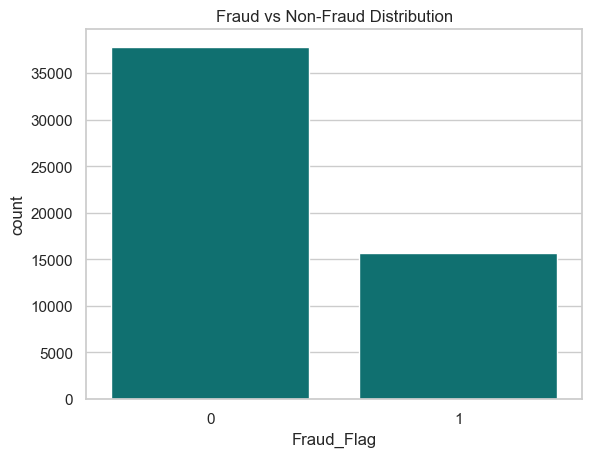

In [4]:
sns.countplot(x='Fraud_Flag', data=df, color="teal")
plt.title("Fraud vs Non-Fraud Distribution")
plt.show()

## ✂️ Train-Test Split

In [5]:
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

leakage_cols = [low_credit] + accident_col + risk_cols + claims_cols + [coverage, deductible]

df_model = df.drop(columns=leakage_cols)


# ---------------------------
# 3. Split X and y
# ---------------------------
X = df_model.drop('Fraud_Flag', axis=1)
y = df_model['Fraud_Flag']


# ---------------------------
# 4. Apply Chi-Square Feature Selection
# ---------------------------
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

selector = SelectKBest(score_func=chi2, k=10)
X_selected = selector.fit_transform(X_scaled, y)

selected_features = X.columns[selector.get_support()]
print("Selected Features:", selected_features)




Selected Features: Index(['Occupation_Lawyer', 'Occupation_Salesperson',
       'Geographic Information_Sikkim', 'Insurance Products Owned_policy2',
       'Customer Preferences_Mail', 'Customer Preferences_Phone',
       'Preferred Communication Channel_Text',
       'Preferred Contact Time_Evening', 'Life Events_Divorce',
       'Life Events_Marriage'],
      dtype='object')


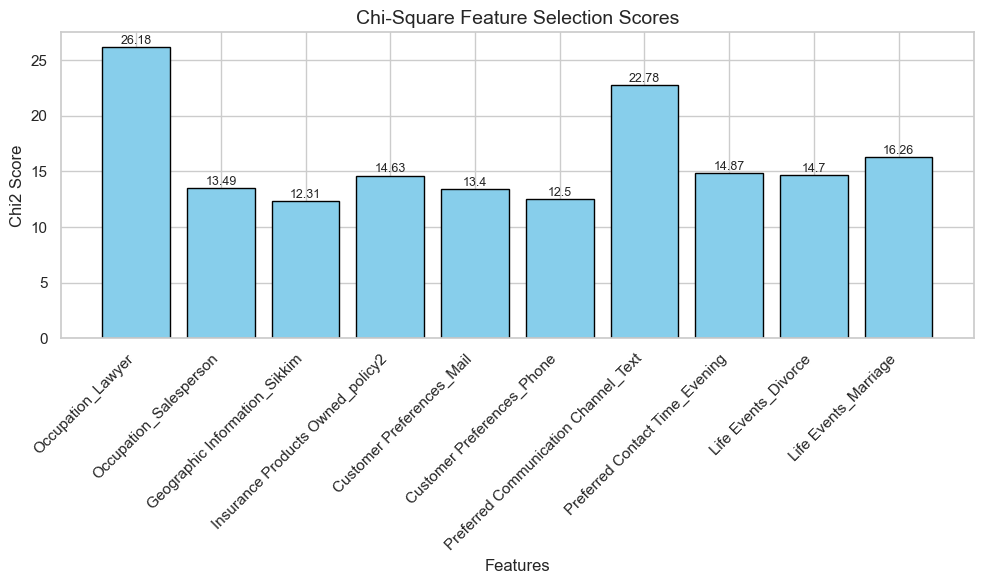

In [6]:
# Plot bar chart on chi-square feature scores
chi2_scores = selector.scores_
selected_scores = chi2_scores[selector.get_support()]
plt.figure(figsize=(10, 6))
bars = plt.bar(selected_features, selected_scores, color="skyblue", edgecolor="black")

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.01, round(yval, 2),
             ha="center", va="bottom", fontsize=9)

plt.title("Chi-Square Feature Selection Scores", fontsize=14)
plt.xlabel("Features", fontsize=12)
plt.ylabel("Chi2 Score", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()



In [7]:
X = df.drop(columns=['Fraud_Flag'])
y = df['Fraud_Flag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape

((40127, 108), (13376, 108))

## 🤖 Train ML Models
Models:
- Logistic Regression
- Random Forest
- Decision Tree
- KNN

In [8]:
# ---------------------------
# Use Chi-Square selected features
# ---------------------------
X_train_selected = X_train[selected_features]
X_test_selected = X_test[selected_features]

# Define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Decision Tree": DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=20,
        min_samples_leaf=10,
        class_weight="balanced",
        random_state=42
    ),
    "KNN": KNeighborsClassifier(
        n_neighbors=3,
        algorithm="kd_tree",
        weights="distance",
        leaf_size=30
    )
}

# Apply PCA for KNN (on selected features only)
pca = PCA(n_components=min(20, X_train_selected.shape[1]), random_state=42)
X_train_pca = pca.fit_transform(X_train_selected)
X_test_pca = pca.transform(X_test_selected)

results = {}

for name, model in models.items():
    if name == "KNN":
        model.fit(X_train_pca, y_train)
        preds = model.predict(X_test_pca)
        proba = model.predict_proba(X_test_pca)[:, 1]
    else:
        model.fit(X_train_selected, y_train)
        preds = model.predict(X_test_selected)
        proba = model.predict_proba(X_test_selected)[:, 1]

    results[name] = {
        "model": model,
        "preds": preds,
        "proba": proba
    }

    print(f"\n{name} Results")
    print(classification_report(y_test, preds))



Logistic Regression Results
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      9446
           1       0.00      0.00      0.00      3930

    accuracy                           0.71     13376
   macro avg       0.35      0.50      0.41     13376
weighted avg       0.50      0.71      0.58     13376


Random Forest Results
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      9446
           1       0.42      0.00      0.01      3930

    accuracy                           0.71     13376
   macro avg       0.57      0.50      0.42     13376
weighted avg       0.62      0.71      0.59     13376


Decision Tree Results
              precision    recall  f1-score   support

           0       0.72      0.48      0.57      9446
           1       0.31      0.56      0.40      3930

    accuracy                           0.50     13376
   macro avg       0.52      0.52      0.49     13376

## 🔍 Confusion Matrices

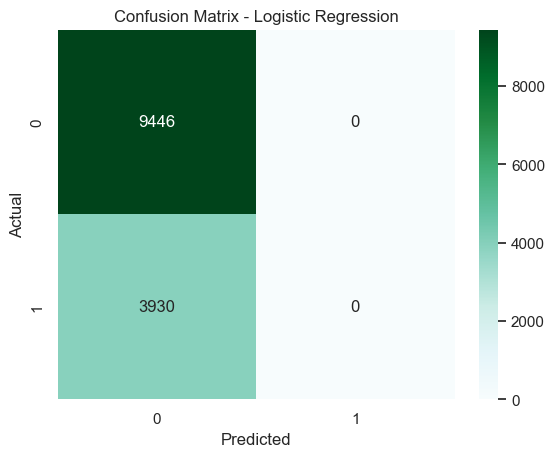

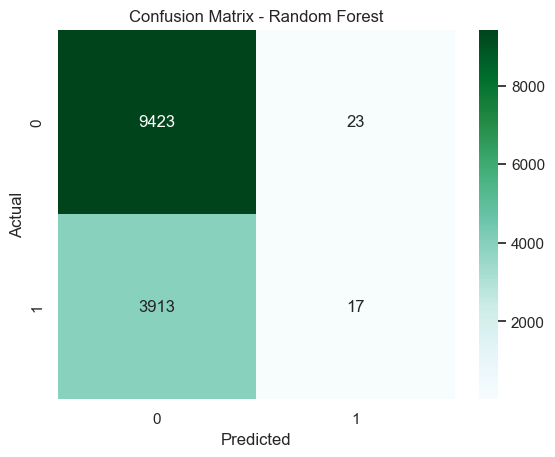

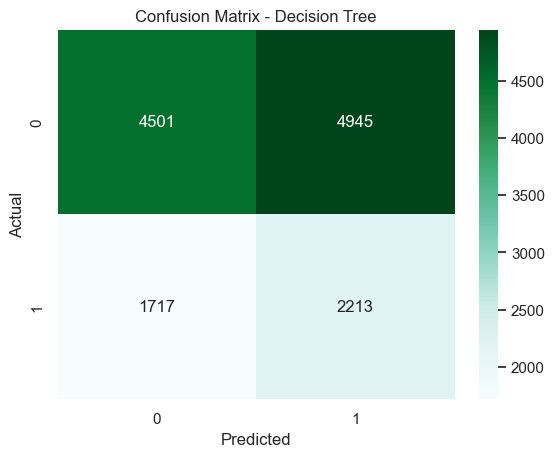

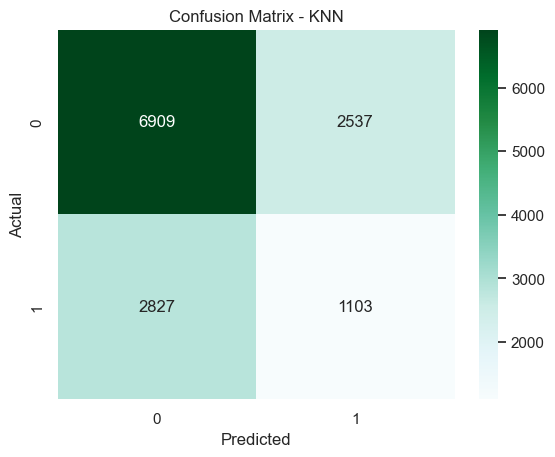

In [9]:
def plot_confusion_matrices(results, y_test):
    for name, res in results.items():
        cm = confusion_matrix(y_test, res["preds"])
        sns.heatmap(cm, annot=True, fmt="d", cmap="BuGn")
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

plot_confusion_matrices(results, y_test)

## 📊 Model Evaluation Summary

This section compares the performance of all trained models using:

- **AUC Scores**
- **ROC Curves**
- **Leaderboard Ranking**

These metrics help evaluate how well each model distinguishes between **fraud** and **non‑fraud** cases — a critical requirement in insurance fraud detection.

---

### ✅ AUC Score (Area Under ROC Curve)

AUC measures the model’s ability to separate the classes across all thresholds.  
Higher AUC = better fraud detection performance.

---

### ✅ Model Leaderboard

The leaderboard ranks all models based on their AUC scores, from best to worst.

---

### ✅ ROC Curve Comparison

The ROC curve visualizes the trade‑off between **True Positive Rate** and **False Positive Rate** for each model.

A model closer to the **top‑left corner** performs better.

---

AUC Scores:


{'Logistic Regression': 0.5342669514513729,
 'Random Forest': 0.5273821087752587,
 'Decision Tree': 0.5286016968556773,
 'KNN': 0.5032511169691494}


Model Leaderboard:


,Model,AUC Score
0,Logistic Regression,0.534267
1,Decision Tree,0.528602
2,Random Forest,0.527382
3,KNN,0.503251


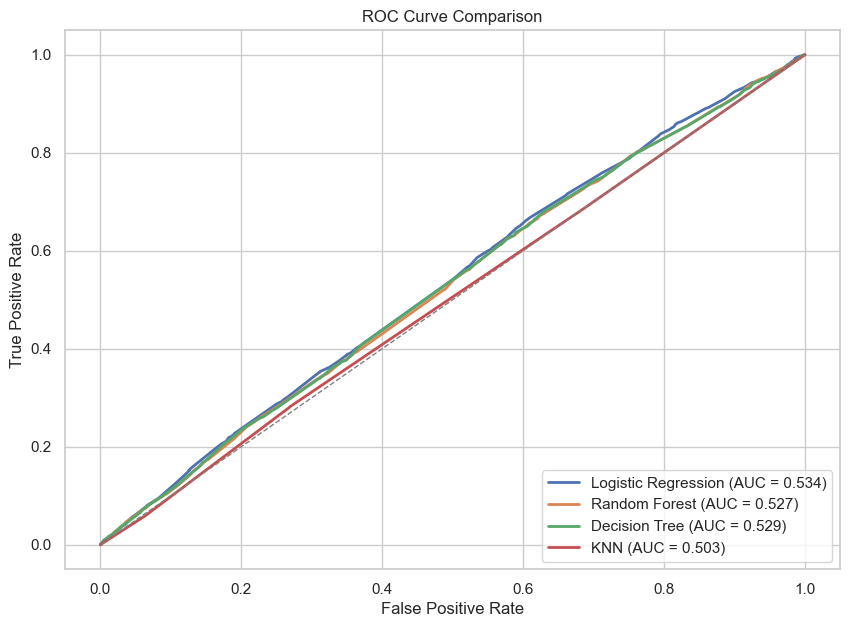

,Model,AUC Score
0,Logistic Regression,0.534267
1,Decision Tree,0.528602
2,Random Forest,0.527382
3,KNN,0.503251


In [10]:
def plot_auc_and_roc(results, y_test):
    """Compute AUC scores, show leaderboard, and plot ROC curves for all models."""
    
    # 1. Compute AUC Scores
    auc_scores = {name: roc_auc_score(y_test, res["proba"]) for name, res in results.items()}
    
    # 2. Create Leaderboard
    leaderboard = pd.DataFrame({
        "Model": list(auc_scores.keys()),
        "AUC Score": list(auc_scores.values())
    }).sort_values(by="AUC Score", ascending=False).reset_index(drop=True)
    
    print("AUC Scores:")
    display(auc_scores)
    
    print("\nModel Leaderboard:")
    display(leaderboard)
    
    # 3. Plot ROC Curves
    plt.figure(figsize=(10, 7))
    for name, res in results.items():
        fpr, tpr, _ = roc_curve(y_test, res["proba"])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=2, label=f"{name} (AUC = {roc_auc:.3f})")
    
    plt.plot([0, 1], [0, 1], color="gray", lw=1, linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve Comparison")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    
    return leaderboard

leaderboard = plot_auc_and_roc(results, y_test)
leaderboard

In [11]:
# ---------------------------
# Define parameter grids
# ---------------------------
param_grids = {
    "Logistic Regression": {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs"]
    },
    "Random Forest": {
        "clf__n_estimators": [100, 200, 300],
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 10],
        "clf__class_weight": ["balanced"]
    },
    "Decision Tree": {
        "clf__max_depth": [None, 10, 20],
        "clf__min_samples_split": [2, 10, 20],
        "clf__min_samples_leaf": [1, 5, 10],
        "clf__class_weight": ["balanced"]
    },
    "KNN": {
        "pca__n_components": [10, 20],
        "clf__n_neighbors": [3, 5, 7],
        "clf__weights": ["uniform", "distance"],
        "clf__algorithm": ["kd_tree", "ball_tree"]
    }
}

# ---------------------------
# Define pipelines
# ---------------------------
pipelines = {
    "Logistic Regression": Pipeline([("clf", LogisticRegression(max_iter=1000))]),
    "Random Forest": Pipeline([("clf", RandomForestClassifier(random_state=42))]),
    "Decision Tree": Pipeline([("clf", DecisionTreeClassifier(random_state=42))]),
    "KNN": Pipeline([
        ("pca", PCA(random_state=42)),
        ("clf", KNeighborsClassifier())
    ])
}

# ---------------------------
# Run GridSearchCV for each model
# ---------------------------
results = {}

for name, pipeline in pipelines.items():
    print(f"\nTuning {name}...")
    grid = GridSearchCV(
        pipeline,
        param_grids[name],
        scoring="roc_auc",   
        cv=5,
        n_jobs=-1
    )
    grid.fit(X_train_selected, y_train)

    best_model = grid.best_estimator_
    preds = best_model.predict(X_test_selected)
    proba = best_model.predict_proba(X_test_selected)[:, 1]

    results[name] = {
        "best_params": grid.best_params_,
        "best_score": grid.best_score_,
        "model": best_model,
        "preds": preds,
        "proba": proba
    }

    print(f"Best Params: {grid.best_params_}")
    print(f"CV Best AUC: {grid.best_score_:.3f}")
    print("\nTest Results:")
    print(classification_report(y_test, preds))


Tuning Logistic Regression...
Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
CV Best AUC: 0.533

Test Results:
              precision    recall  f1-score   support

           0       0.71      1.00      0.83      9446
           1       0.00      0.00      0.00      3930

    accuracy                           0.71     13376
   macro avg       0.35      0.50      0.41     13376
weighted avg       0.50      0.71      0.58     13376


Tuning Random Forest...
Best Params: {'clf__class_weight': 'balanced', 'clf__max_depth': 10, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
CV Best AUC: 0.517

Test Results:
              precision    recall  f1-score   support

           0       0.72      0.48      0.58      9446
           1       0.31      0.56      0.40      3930

    accuracy                           0.51     13376
   macro avg       0.52      0.52      0.49     13376
weighted avg       0.60      0.51      0.53     13376


Tuning Decision Tree...


## Hyperparameter Tuning
We used **GridSearchCV** with cross-validation to tune Logistic Regression, Random Forest, Decision Tree, and KNN (with PCA).  
Despite optimization, the **AUC scores stayed around ~0.53**, showing that model limits come from data imbalance and weak feature signal rather than parameters.

In [14]:
lb = leaderboard.copy()

fig, ax = plt.subplots(figsize=(10, 4))
ax.axis('off')

table = ax.table(
    cellText=lb.values,
    colLabels=lb.columns,
    loc='center',
    cellLoc='center'
)

# Apply colors cell-by-cell
for (row, col), cell in table.get_celld().items():
    if row == 0:
        cell.set_facecolor("#008080")
        cell.set_text_props(color="white", weight="bold")
    else:
        value = lb.iloc[row-1, col]

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)

plt.savefig("../visuals/model_leaderboard.png", dpi=300, bbox_inches='tight')
plt.close()
print("Leaderboard exported as model_leaderboard.png")

Leaderboard exported as model_leaderboard.png


## 💾 Save Best Model

In [15]:
import pickle

# Get top-ranked model from leaderboard
best_model_name = leaderboard.loc[0, "Model"]
print("Top-ranked model:", best_model_name)

# Retrieve the model object
best_model = results[best_model_name]["model"]

with open("../models/fraud_detection_model.pkl", "wb") as obj:
    pickle.dump(best_model, obj)

print(f"Best model ({best_model_name}) for Fraud Detection saved successfully!")

Top-ranked model: Logistic Regression
Best model (Logistic Regression) for Fraud Detection saved successfully!


## ✅ Next Steps

- Integrate the saved model into Flask API (`/predict`)
- Build Streamlit dashboard for fraud prediction
- Deploy end-to-end fraud detection pipeline